# Chainer チュートリアル その4

https://qiita.com/mitmul/items/eccf4e0a84cb784ba84a
のなかから、Chainarでデータセットクラスを作成してみる。



##  前回の復習


In [10]:
import chainer
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions
import chainer.links as L
import chainer.functions as F


def train(model_object, batchsize=64, gpu_id=0, max_epoch=20, train_dataset=None, test_dataset=None):

    # 1. Dataset
    if train_dataset is None and test_dataset is None:
        train, test = cifar.get_cifar10()
    else:
        train, test = train_dataset, test_dataset

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{0}_{1}_result'.format(model_object.__class__.__name__,train_dataset.__class__.__name__))

    # 7. Evaluator

    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            model.train = False
            ret = super(TestModeEvaluator, self).evaluate()
            model.train = True
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer

    return model

class ConvBlock(chainer.Chain):
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__(
            conv=L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w),
            bn=L.BatchNormalization(n_ch)
        )

        self.train = True
        self.pool_drop = pool_drop

    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):

    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__(
            fc=L.Linear(None, 1024, initialW=w))
        self.train = True

    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5)

class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        self._train = True

    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, val):
        self._train = val
        for c in self.children():
            c.train = val

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x



## データセットクラスの作成

Deep leariningを行う際、データセットに何かしらの変更を加えて、学習成果を上げることはよく行われる。
これをData augmentationと呼ぶ。Chainerでは、データセットクラスにData augmentationの内容を記述する。

それでは、CIFAR10のデータを使って、データセットクラスを自分で作成してみよう。

Chainerでは、データセットを表すクラスは以下の機能を実装する。

- データセット内のデータ数を返す__len__メソッド
- 引数として渡されるiに対応したデータもしくはデータとラベルの組を返すget_exampleメソッド

その他の必要な機能は、chainer.dataset.DatasetMixinクラスを継承することで用意できる。
Data augmentation機能のついたデータセットクラスを作成する際には、DatasetMixinクラスを継承しよう。

これから作成するクラスは、CIFAR10のデータのそれぞれに対し、

- 32x32の大きさの中からランダムに28x28の領域をクロップ
- 1/2の確率で左右を反転させる

という加工を行なう。

これらの操作を行ない、学習データのバリエーションを増やすと、過学習抑制できることが知られている。
他には、画像の色味を変化させるような変換、ランダムな回転、アフィン変換、などの加工によって学習データ数を擬似的に増やす方法が提案されているので、それらを使うとより効果的な学習を行うことができるだろう。

自分でデータの取得する場合は、コンストラクタに画像フォルダのパスとファイル名に対応したラベルの書かれたテキストファイルへのパスなどを渡してプロパティとして保持しておき、get_exampleメソッド内でそれぞれの画像を読み込んで対応するラベルとともに返す、という処理を記述する。



In [11]:
import numpy as np
from chainer import dataset
from chainer.datasets import cifar

class CIFAR10Augmented(dataset.DatasetMixin):

    def __init__(self, train=True):
        train_data, test_data = cifar.get_cifar10()
        if train:
            self.data = train_data
        else:
            self.data = test_data
        self.train = train
        self.random_crop = 4 #端から4ピクセル削る

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        x, t = self.data[i]
        if self.train: # trainingの時は・・・
            x = x.transpose(1, 2, 0)  # 2次元にする
            h, w, _ = x.shape
            x_offset = np.random.randint(self.random_crop) # 中心からのずれを
            y_offset = np.random.randint(self.random_crop) # 乱数で決める
            x = x[y_offset:y_offset + h - self.random_crop,
                  x_offset:x_offset + w - self.random_crop] #領域をクロップする
            if np.random.rand() > 0.5:
                x = np.fliplr(x) # 確率1/2で左右反転
            x = x.transpose(2, 0, 1) #1次元に戻す
        return x, t

## 2. 作成したデータセットクラスで学習を行う

作成した`CIFAR10Augmented`クラスを使って学習を行う。
この時、Tutorial3で使ったものと同じネットワークを使い、Data augmentationの効果を調べよう。

train関数も含め、データセットクラス以外は全く同じである。train関数を呼び出すときに、エポック数と保存先ディレクトリ名の指定を変える。

In [12]:
model = train(DeepCNN(10), max_epoch=100, train_dataset=CIFAR10Augmented(), test_dataset=CIFAR10Augmented(False))

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.95788     0.271859       1.78234               0.338177                  23.9495       
2           1.47035     0.458627       1.25331               0.561604                  48.4371       
3           1.23208     0.56232        1.02791               0.654359                  72.4059       
4           1.0711      0.635423       1.224                 0.671875                  96.5167       
5           0.939969    0.686521       0.828723              0.727607                  120.558       
6           0.805217    0.734835       0.672384              0.772393                  144.823       
7           0.709882    0.765845       0.643962              0.789311                  168.943       
8           0.640138    0.791433       0.635924              0.788615                  193.134       
9           0.593737    0.804767       0.51822               0.826732               

79          0.100052    0.96915        0.40369               0.917197                  1913.5        
80          0.0978809   0.96905        0.349678              0.91043                   1937.76       
81          0.0930212   0.971248       0.459411              0.909634                  1961.99       
82          0.0948304   0.96945        0.382955              0.914013                  1986.29       
83          0.0948265   0.96979        0.469219              0.911624                  2010.57       
84          0.0925488   0.970651       0.455285              0.912122                  2034.7        
85          0.0961631   0.969509       0.371529              0.9166                    2058.91       
86          0.0946538   0.970591       0.438699              0.91033                   2083.13       
87          0.0946322   0.971271       0.439265              0.909634                  2107.3        
88          0.0898832   0.971931       0.457036              0.909733             

前回の精度が88%、今回は91%だ。3%ほどの向上が見られた。学習時間は40分ほどであった。

最後に、損失と精度のグラフを見てみよう。

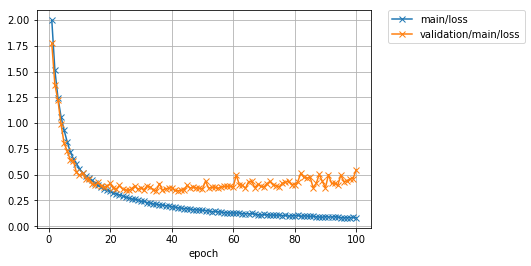

In [13]:
from IPython.display import Image
Image(filename='DeepCNN_cifar10_result/loss.png')

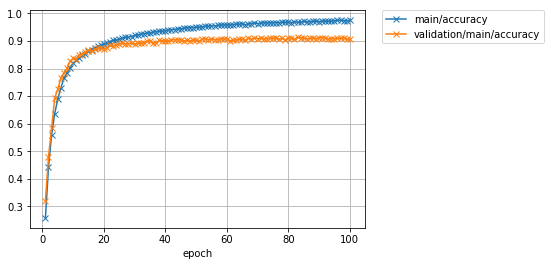

In [14]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')